# Non-IQ investigation

In [1]:
# . Honours Module Folder
# ├ FYPLibrary
# | ├ file_reading.py
# | └ IQ_demod.py
# └ Sub Project folder i.e.: os.path.abspath('')
#   ├ this notebook(.ipynb)
#   └ "Batch" folder
#     └ C2-xxxHz-xxxmVpp-80.125xxxMHz-comment.txt

# Initialization: Directory appending for my system. Vary the directories as necessary.
import sys
import os.path
# Add the FYPLibrary folder in the same level as this folder.
parent_dir = os.path.dirname(os.path.abspath(''))
if os.path.join(parent_dir, 'FYPLibrary') not in sys.path:
    sys.path.append(os.path.join(parent_dir, 'FYPLibrary'))
del parent_dir

# from pprint import pprint
# pprint(sys.path)

# within this jupyter notebook
from os import listdir
from file_reading import *
from IQ_demod import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import EPstandard

In [2]:
def drifting_sin(x, A, f, phi, m, c):
    return A * np.sin(2*pi*f*x + phi) + m*x+c

In [3]:
# Step 1: Change the name to which the folder you wish to read from
# Yield all files in batch folder
folderpath = os.path.join(os.path.abspath(''),'Batch 2')

files = listdir(path= folderpath)
for i, f in enumerate(files):
    print(f"{i:>3}: {f}")

  0: 20220127 N_is_8.7z
  1: C1-80.0625MHz-1MSs-0mVpp-140Hz00000.txt
  2: C1-80.0625MHz-1MSs-0mVpp-140Hz00001.txt
  3: C1-80.0625MHz-1MSs-0mVpp-140Hz00002.txt
  4: C1-80.0625MHz-1MSs-0mVpp-140Hz00003.txt
  5: C1-80.0625MHz-1MSs-0mVpp-140Hz00004.txt
  6: C1-80.0625MHz-1MSs-0mVpp-140Hz00005.txt
  7: C1-80.0625MHz-1MSs-250mVpp-140Hz00000.txt
  8: C1-80.0625MHz-1MSs-250mVpp-140Hz00001.txt
  9: C1-80.0625MHz-1MSs-250mVpp-140Hz00002.txt


In [44]:
my_input = 4

if my_input != -1:
    file = files[my_input]

NAME = file
TXT_FILE_PATH = file_str_to_path(NAME, dir= folderpath)

In [45]:
_, SIGNAL_F, SAMPLING_F, mVpp, fMirror = numerical_variables_from_name(NAME) 
SIGNAL_F *= 1.0e6 #MHz to Hz 
SIGNAL_F *= 2
SAMPLING_F *= 1e6
ph_ad = phase_advance(SIGNAL_F, SAMPLING_F) # phase advance = 2*pi/N
N, _ = freq_ratio(signal=SIGNAL_F, sample=SAMPLING_F)
print(f"{N = }")

N = 8


In [46]:
meta, trace = fr.parse_and_read_oscilliscope_txt(TXT_FILE_PATH)
signal = signal_from_trace(np.asarray(trace))

[Notice] Ignore the following mixed types warning.


C:\Users\Thormund\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [47]:
phases_accum = signal_to_phase(signal, N, 2*pi/N, phase_advancement_correction=False)
print(f"{phases_accum[:10] = }")
phases_accum = phase_reconstruction_2(phases_accum, 2*pi/N, False)
print(f"{phases_accum[:10] = }")
t_axis = np.arange(start= 0, 
    stop= (int(meta["Record Length"][0])-N) * meta['Sample Interval'][0], step= meta['Sample Interval'][0])

if mVpp != 0:
    # Regression to obtain mirror freq
    drifting_sin_bounds = ((0.03*mVpp,      0,  -2*pi, -np.inf, -np.inf), \
                           (   np.inf, np.inf,   2*pi,  np.inf,  np.inf))
    popt, pcov = optimize.curve_fit(drifting_sin, t_axis, phases_accum, 
        p0= [0.05*mVpp, fMirror, 0, 0, 0.5*(max(phases_accum[:1000])+min(phases_accum[:1000]))], 
        bounds= drifting_sin_bounds)
    fittings = EPstandard.easy_read_popt_pcov(popt, pcov)

phases_accum[:10] = array([ 1.38138183,  2.18493321,  3.01306824, -2.42293611, -1.92091001,
       -1.1753275 , -0.3123263 ,  0.31455594,  0.97422726,  1.60689219])
phases_accum[:10] = array([1.38138183, 1.39953505, 1.44227192, 1.50405471, 1.22068263,
       1.18086698, 1.25847002, 1.0999541 , 0.97422725, 0.82149402])


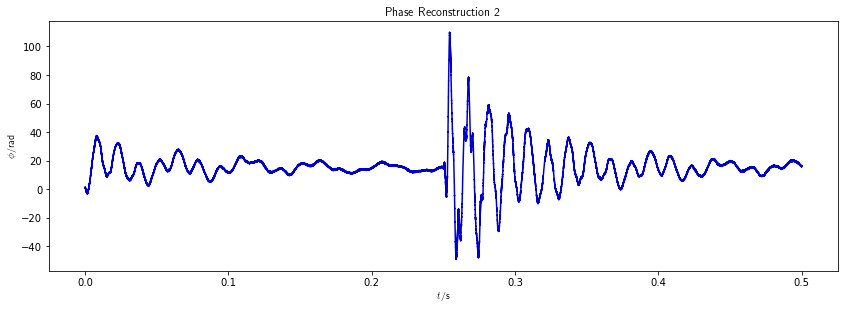

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis, phases_accum, color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"Phase Reconstruction 2", \
    useTex= True )
# powerpoint is 13.333 inches wide by 7.5 inches high
fig.set_size_inches(1.0*(13+1/3-1.5), 0.8*(7.5-2)) 
fig.tight_layout()

phases_accum2[:10] = array([ 1.38138183,  2.18493321,  3.01306824, -2.42293611, -1.92091001,
       -1.1753275 , -0.3123263 ,  0.31455594,  0.97422726,  1.60689219])
deltas.min() = -0.6934154, deltas.max() = 0.79915565


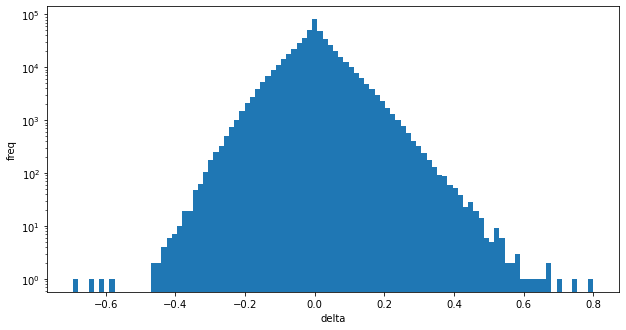

In [49]:
phases_accum2 = signal_to_phase(signal, N, 2*pi/N, phase_advancement_correction=False)
print(f"{phases_accum2[:10] = }")
deltas = phase_reconstruction_2(phases_accum2, 2*pi/N, get_deltas= True)
print(f"{deltas.min() = }, {deltas.max() = }")

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(deltas, bins= 100)
ax.set_yscale('log')
ax.set_ylabel(r'freq', useTex = False)
ax.set_xlabel(r'delta', useTex = False)
fig.set_size_inches(11.75-1.5, 8.25-2 - 1)

[-0.01686856  0.03822906  0.16196284 ... -0.1496349   0.09677344
 -0.01669941]


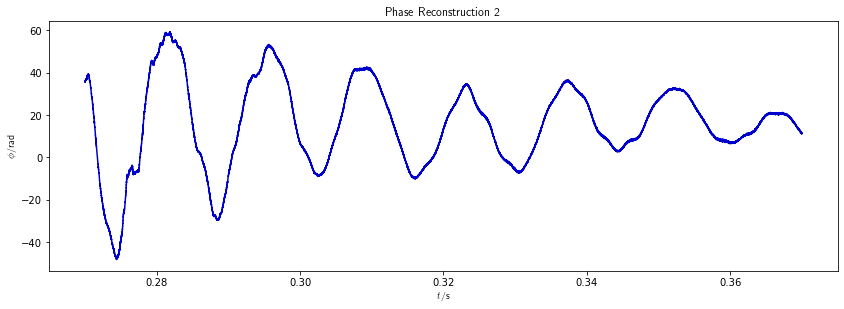

In [50]:
zoom_in_start = 270000
zoom_in_end = zoom_in_start + 100000
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis[zoom_in_start:zoom_in_end], phases_accum[zoom_in_start:zoom_in_end], color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"Phase Reconstruction 2", \
    useTex= True )
# powerpoint is 13.333 inches wide by 7.5 inches high
fig.set_size_inches(1.0*(13+1/3-1.5), 0.8*(7.5-2)) 
fig.tight_layout()
print(deltas[zoom_in_start:zoom_in_end])